__Midterm Project__

__Name: Kenny Chung__

https://www.kaggle.com/datasets/solomonameh/spotify-music-dataset?resource=download

The dataset is collated from Spotify's API using two separate python scripts to extract popular and non-popular songs and their associated audio and descriptive features. Descriptive features of a song include information about the song such as the artist name, album name and release date. Audio features include key, valence , danceability and energy which are results of spotify's audio analysis.

For this project, we will focus on the popular songs only.

I was motivated to use this dataset because I love curating playlists on Spotify based on how "similar" they sound, but haven't yet investigated the underlying factors for why they sound "similar". Also, the Kaggle usability score is 9.41, which is high.

I'm trying to answer: what are the top genres? Is there an association between a song's energy and danceability? Do songs get louder as the years go by?

In [78]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
# Read raw data, in this case only the high popularity Spotify songs
hpsd = Table.read_table('high_popularity_spotify_data.csv')
hpsd.show(10)

energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,track_popularity,track_href,uri,track_album_name,playlist_name,analysis_url,track_id,track_name,track_album_release_date,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,100,https://api.spotify.com/v1/tracks/2plbrEY59IikOBgBGLjaoe,spotify:track:2plbrEY59IikOBgBGLjaoe,Die With A Smile,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/2plbrEY59IikOB ...,2plbrEY59IikOBgBGLjaoe,Die With A Smile,2024-08-16,0,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.308,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,97,https://api.spotify.com/v1/tracks/6dOtVTDdiauQNBQEDOtlAB,spotify:track:6dOtVTDdiauQNBQEDOtlAB,HIT ME HARD AND SOFT,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/6dOtVTDdiauQNB ...,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,2024-05-17,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,93,https://api.spotify.com/v1/tracks/7ne4VBA60CxGM75vw0EYad,spotify:track:7ne4VBA60CxGM75vw0EYad,The Secret of Us (Deluxe),Today's Top Hits,https://api.spotify.com/v1/audio-analysis/7ne4VBA60CxGM7 ...,7ne4VBA60CxGM75vw0EYad,That’s So True,2024-10-18,0,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.214,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
0.91,112.966,0.67,pop,-4.07,0.304,0.786,Sabrina Carpenter,4,0.0634,81,https://api.spotify.com/v1/tracks/1d7Ptw3qYcfpdLNL5REhtJ,spotify:track:1d7Ptw3qYcfpdLNL5REhtJ,Short n' Sweet,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/1d7Ptw3qYcfpdL ...,1d7Ptw3qYcfpdLNL5REhtJ,Taste,2024-08-23,0,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.26,98,https://api.spotify.com/v1/tracks/5vNRhkKd0yEAg8suGBpjeY,spotify:track:5vNRhkKd0yEAg8suGBpjeY,APT.,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/5vNRhkKd0yEAg8 ...,5vNRhkKd0yEAg8suGBpjeY,APT.,2024-10-18,0,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
0.582,116.712,0.7,pop,-5.96,0.0881,0.785,Chappell Roan,4,0.0356,94,https://api.spotify.com/v1/tracks/0WbMK4wrZ1wFSty9F7FCgu,spotify:track:0WbMK4wrZ1wFSty9F7FCgu,"Good Luck, Babe!",Today's Top Hits,https://api.spotify.com/v1/audio-analysis/0WbMK4wrZ1wFSt ...,0WbMK4wrZ1wFSty9F7FCgu,"Good Luck, Babe!",2024-04-05,0,1WAjjRMfZjEXtB0lQrAw6Q,0,11,218424,0.0502,0WbMK4wrZ1wFSty9F7FCgu,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
0.561,150.069,0.669,pop,-6.538,0.0954,0.841,Addison Rae,4,0.0411,88,https://api.spotify.com/v1/tracks/6MzofobZt2dm0Kf1hTThFz,spotify:track:6MzofobZt2dm0Kf1hTThFz,Diet Pepsi,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/6MzofobZt2dm0K ...,6MzofobZt2dm0Kf1hTThFz,Diet Pepsi,2024-08-09,0.00962,0XA403JTounqFh2owquBXu,1,10,169698,0.495,6MzofobZt2dm0Kf1hTThFz,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
0.247,148.101,0.467,pop,-12.002,0.17,0.126,Billie Eilish,4,0.0431,93,https://api.spotify.com/v1/tracks/3QaPy1KgI7nu9FJEQUgn6h,spotify:track:3QaPy1KgI7nu9FJEQUgn6h,HIT ME HARD AND SOFT,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/3QaPy1KgI7nu9F ...,3QaPy1KgI7nu9FJEQUgn6h,WILDFLOWER,2024-05-17,0.000271,7aJuG4TFXa2hmE4z1yxc3n,0,6,261467,0.612,3QaPy1KgI7nu9FJEQUgn6h,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
0.416,94.926,0.492,pop,-10.439,0.203,0.297,Gigi Perez,4,0.0254,71,https://api.spotify.com/v1/tracks/0UYnhUfnUj5adChuAXvLUB,spotify:track:0UYnhUfnUj5adChuAXvLUB,Sailor Song,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/0UYnhUfnUj5adC ...,0UYnhUfnUj5adChuAXvLUB,Sailor Song

In [80]:
# Select only the columns we're interested in:
spotify = hpsd.select('track_name','track_artist','playlist_genre','track_album_release_date','track_popularity','energy','tempo','danceability','loudness','valence')
spotify.relabel('track_name','song')
spotify.relabel('track_artist','artist')
spotify.relabel('playlist_genre','genre')
spotify.relabel('track_album_release_date','release_date')
spotify.relabel('track_popularity','popularity')
spotify.relabel('valence','positiveness')
spotify.show(3)

song,artist,genre,release_date,popularity,energy,tempo,danceability,loudness,positiveness
Die With A Smile,"Lady Gaga, Bruno Mars",pop,2024-08-16,100,0.592,157.969,0.521,-7.777,0.535
BIRDS OF A FEATHER,Billie Eilish,pop,2024-05-17,97,0.507,104.978,0.747,-10.171,0.438
That’s So True,Gracie Abrams,pop,2024-10-18,93,0.808,108.548,0.554,-4.169,0.372


__I selected the above columns from the original dataset because we need the song and artist names by default to identify the song. This is usually how songs are identified in everyday conversations, as opposed to something like a track id.__

I also chose these columns because they are all different measures of a song's "energy" in different ways. The following are the definitions from the Kaggle source:

ENERGY: A measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.

TEMPO: The speed of a track, measured in beats per minute (BPM).

DANCEABILITY: A score describing how suitable a track is for dancing based on tempo, rhythm stability, beat strength and overall regularity.

LOUDNESS: The overall loudness of a track in decibels (dB). Higher values indicate louder tracks overall.

POSITIVENESS (VALENCE): The overall musical positiveness(emotion) of a track. High valence sounds happy; low valence sounds sad or angry.

TRACK POPULARITY: A score (0–100) which is calculated based on total number of streams in relation to other songs.

PLAYLIST GENRE: The main genre associated with the playlist (e.g., pop, rock, classical).

__Question 1: Are there duplicate songs in the spotify table? If so, how many extra copies are there?__

__Question 2: How many unique songs are there?__

In [81]:
# Get all songs that HAVE duplicates
dup_songs = spotify.group('song').where('count',are.above(1)).sort('count',descending=True)
dup_songs.show(3)
print('# of songs that HAVE duplicates: '+str(dup_songs.num_rows))

# To get the number of extra copies, sum up the count column 
# and subtract by the number of rows (aka the # of unique copies)
num_dup_song_copies = sum(dup_songs.column('count')) - dup_songs.num_rows
print('# of extra song copies: '+str(num_dup_song_copies))
print('# of songs in original table: ' + str(spotify.num_rows))
print('# of unique songs: '+str(spotify.num_rows - num_dup_song_copies))

song,count
Too Sweet,5
Iris,4
Lose Control,4


# of songs that HAVE duplicates: 224
# of extra song copies: 278
# of songs in original table: 1686
# of unique songs: 1408


__Question 3: Create a modified copy of the spotify table so that it only contains unique songs, while retaining the rest of the information such as artist and genre for each unique song.__

In [82]:
# Helper function:
def first(an_array):
    return an_array.item(0)

# Group by song, then keep the first values from each group
all_unique_songs = spotify.group('song', first)
print('Double check: # of unique songs: '+str(all_unique_songs.num_rows))

# Relabel the columns again:
all_unique_songs.relabel('artist first','artist')
all_unique_songs.relabel('genre first','genre')
all_unique_songs.relabel('release_date first','release_date')
all_unique_songs.relabel('popularity first','popularity')
all_unique_songs.relabel('energy first','energy')
all_unique_songs.relabel('tempo first','tempo')
all_unique_songs.relabel('danceability first','danceability')
all_unique_songs.relabel('loudness first','loudness')
all_unique_songs.relabel('positiveness first','positiveness')
all_unique_songs.show(3)

Double check: # of unique songs: 1408


song,artist,genre,release_date,popularity,energy,tempo,danceability,loudness,positiveness
(Don't Fear) The Reaper,Blue Öyster Cult,rock,1976,75,0.927,141.466,0.333,-8.55,0.385
(I Can't Get No) Satisfaction - Mono Version,The Rolling Stones,rock,1965-07-30,76,0.863,136.302,0.723,-7.89,0.931
(It Goes Like) Nanana - Edit,Peggy Gou,electronic,2023-06-15,75,0.876,129.998,0.671,-5.681,0.964


__Question 4: What are the top 3 artists that have the most songs? How many songs do they each have?__

In [83]:
songs_by_artist = all_unique_songs.group('artist').sort('count',descending=True)
songs_by_artist.show(3)

artist,count
Bad Bunny,20
Linkin Park,10
Red Hot Chili Peppers,9


__Question 5: What are the top 3 genres? How many songs are in each genre?__

In [84]:
songs_by_genre = all_unique_songs.group('genre').sort('count',descending=True)
songs_by_genre.show(3)

top_genres = songs_by_genre.column(0).take(np.arange(3))
print('The top 3 genres in order are: ' + str(top_genres))

genre,count
pop,287
rock,203
hip-hop,200


The top 3 genres in order are: ['pop' 'rock' 'hip-hop']


__Question 6: What are the top 3 pop songs in terms of popularity? Also show their respective artists and popularity scores.__

In [85]:
top_pop_songs = all_unique_songs.where('genre','pop').select('song','artist','popularity')
top_pop_songs.sort('popularity',descending=True).show(3)

song,artist,popularity
Die With A Smile,"Lady Gaga, Bruno Mars",100
APT.,"ROSÉ, Bruno Mars",98
BIRDS OF A FEATHER,Billie Eilish,97


__Question 7: Create a scatter plot which shows the relationship between 2 numerical variables: energy vs. danceability. Do this for the pop genre, then the rock genre.__

A scatter plot makes sense because we are checking for any association between 2 numerical variables. Each dot on the scatter plot represents a unique song.

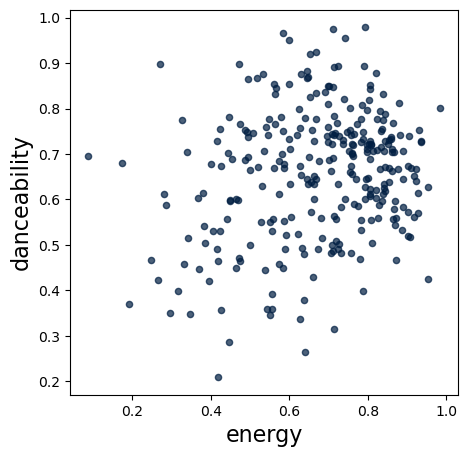

In [86]:
all_unique_songs.where('genre','pop').scatter('energy','danceability')

Visually speaking, there seems to be a slight positive correlation between energy and danceability for the pop genre.

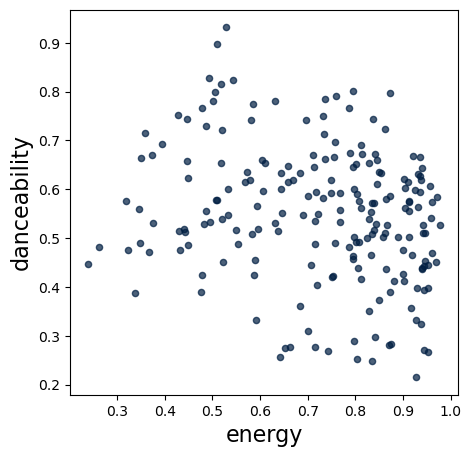

In [87]:
all_unique_songs.where('genre','rock').scatter('energy','danceability')

Conversely, there seems to be a slight negative correlation between energy and danceability for the rock genre.

__Question 8: Create a line plot which shows how the average loudness of our music data changes over time.__

A line plot makes sense in this case because having time on the x-axis is a classic application of it. We can observe trends over time.

In [88]:
sorted_by_date = all_unique_songs.sort('release_date')
sorted_by_date.show(3)

song,artist,genre,release_date,popularity,energy,tempo,danceability,loudness,positiveness
Unforgettable,Nat King Cole,jazz,1954-01-01,69,0.182,136.094,0.349,-13.507,0.178
Jingle Bell Rock,Bobby Helms,pop,1957-12-02,80,0.424,119.705,0.754,-8.463,0.806
Stand By Me,Ben E. King,blues,1962-08-20,75,0.306,118.068,0.65,-9.443,0.605


In [89]:
# Helper function
def extract_year(date_string):
    return date_string[:4]

# Replace release_date with release_year.
# But first, extract the release year by applying get_year on release_date.
sorted_by_year = sorted_by_date.with_column('release_year',sorted_by_date.apply(extract_year,'release_date')).drop('release_date')

In [90]:
# For each year, calculate the averages of all columns
means_per_year = sorted_by_year.group('release_year',np.mean)
means_per_year.show(10)

release_year,song mean,artist mean,genre mean,popularity mean,energy mean,tempo mean,danceability mean,loudness mean,positiveness mean
1954,,,,69,0.182,136.094,0.349,-13.507,0.178
1957,,,,80,0.424,119.705,0.754,-8.463,0.806
1962,,,,75,0.306,118.068,0.65,-9.443,0.605
1964,,,,83,0.47,67.086,0.598,-8.744,0.879
1965,,,,76,0.863,136.302,0.723,-7.89,0.931
1966,,,,78.5,0.657,128.787,0.5585,-9.7155,0.717
1967,,,,72,0.751,89.839,0.421,-9.584,0.789
1968,,,,72,0.805,113.253,0.438,-6.237,0.564
1969,,,,73.5,0.639,127.257,0.471,-11.7565,0.305
1970,,,,79.5,0.8145,114.523,0.6525,-8.548,0.6965


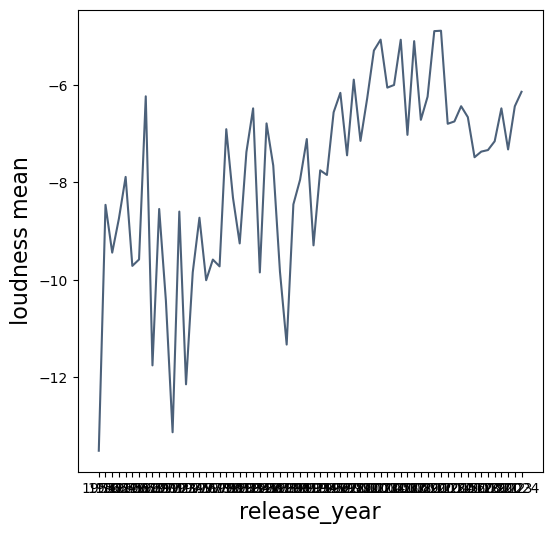

In [91]:
means_per_year.plot('release_year','loudness mean')

Visually, we can see a clear increasing trend in loudness as the years go by from 1954 all the way to 2024.

__Question 9: Create a histogram that shows the danceability distributions of the top 3 genres overlaid on top of each other.__

It makes sense to use a histogram because danceability is a numerial variable with a distribution that ranges from low to high. A histogram would show where the most common values are.

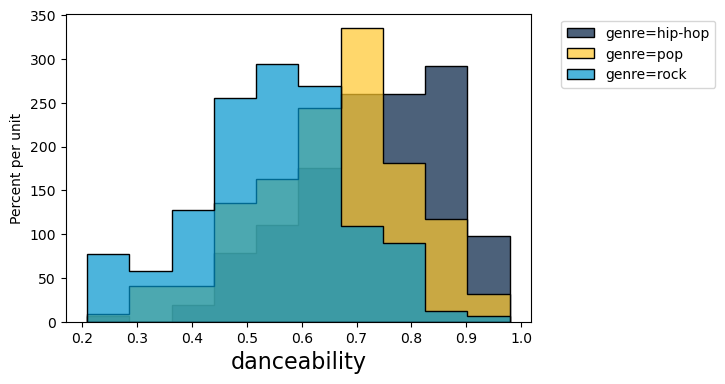

In [92]:
top_genre_rows = all_unique_songs.where('genre',are.contained_in(top_genres))
top_genre_rows.hist('danceability',group='genre')

We can visually see that hip-hop tends to have higher danceability values than pop, which tends to have higher danceability values than rock.

__CONCLUSION__

For the most part, the visual findings were in line with my expectations. I did expect that more modern songs are on average more loud than older songs, based on my personal experience.

It was very neat writing my own report like this, as I often had to go back to previous steps to augment my data set to answer new questions that popped up.